In [1]:
import pandas as pd
from scipy.stats import pearsonr

from modules.plotting_scripts import plot_surprisals, get_avg_df, plot_avg_pos_neg

In [2]:
def calculate_correlations(group, pairs):
    correlations = {}
    for col1, col2 in pairs:
        if len(group) < 2:
            correlations[f"{col1}_{col2}_corr"] = None
        else:
            corr, _ = pearsonr(group[col1], group[col2])
            correlations[f"{col1}_{col2}_corr"] = corr
    return pd.Series(correlations)

In [3]:
path = '../results/lexique_results/indiv_surprisals_full.tsv'
indiv_surprisals = pd.read_csv(path, delimiter='\t')

indiv_surprisals = indiv_surprisals.assign(
    MeanSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['Surprisal'].transform('mean'),
    MeanNegSurprisal=indiv_surprisals.groupby(['Steps', 'Token'])['NegSurprisal'].transform('mean')
)

indiv_surprisals

,Steps,Token,Context,Surprisal,NegSurprisal,MeanSurprisal,MeanNegSurprisal
0,0,a,"[101, 2728, 8945, 11314, 2121, 2003, 2019, 239...",14.215013,14.323027,14.225594,14.234500
1,0,a,"[101, 2023, 2001, 2628, 2011, 103, 4626, 2535,...",13.940619,14.543520,14.225594,14.234500
2,0,a,"[101, 1999, 2432, 8945, 11314, 2121, 5565, 103...",14.588675,14.688922,14.225594,14.234500
3,0,a,"[101, 2002, 2001, 2856, 2011, 2198, 14381, 199...",13.849343,14.169744,14.225594,14.234500
4,0,a,"[101, 2002, 2596, 2006, 1037, 2294, 2792, 1997...",13.696613,13.988950,14.225594,14.234500
...,...,...,...,...,...,...,...
3064889,2000000,zoom,"[101, 2002, 2915, 1996, 2878, 2143, 2012, 1996...",1.668615,7.264644,2.738938,13.967112
3064890,2000000,zu,"[101, 1996, 2047, 2142, 2163, 3212, 103, 2213,...",0.002864,29.544127,2.828315,27.215050
3064891,2000000,zu,"[101, 4415, 11383, 4874, 22486, 1005, 1055, 64...",0.000113,28.785532,2.828315,27.215050
3064892,2000000,zu,"[101, 2002, 2036, 2354, 1010, 2030, 2018, 2081...",6.268449,24.433737,2.828315,27.215050


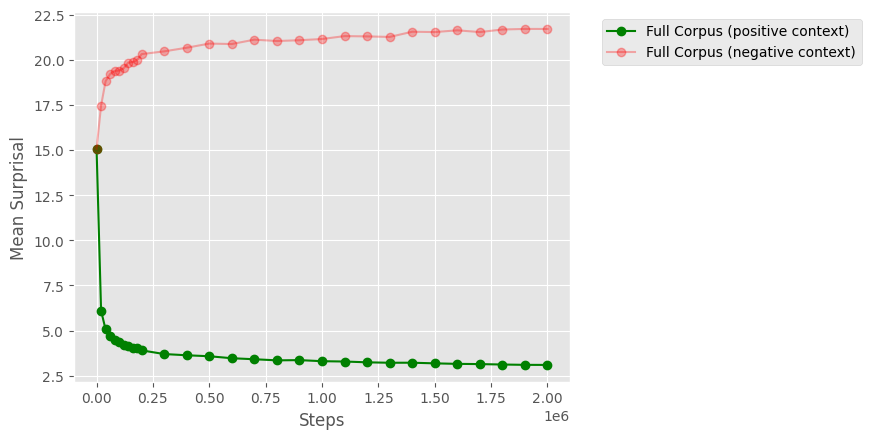

In [4]:
positives = get_avg_df([indiv_surprisals], column='MeanSurprisal')
negatives = get_avg_df([indiv_surprisals], column='MeanNegSurprisal')

plot_avg_pos_neg(positives, negatives)

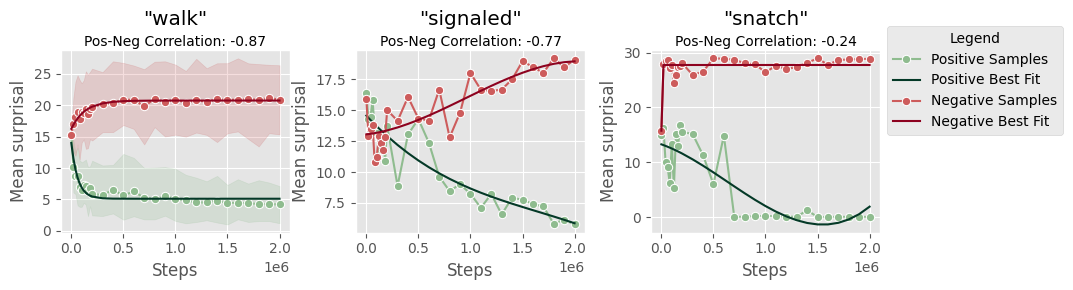

In [5]:
words = ['walk', 'signaled', 'snatch']  # 'the', 'a', 'and', 'runaway', 'lightweight', 'fined'
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False)  

In [6]:
token_counts = indiv_surprisals[indiv_surprisals.Steps == 0].Token.value_counts().reset_index()

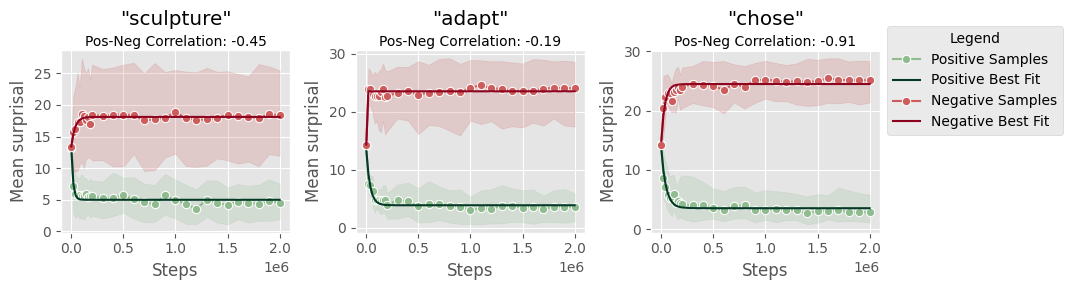

In [7]:
# 10 samples (e.g: "contact", "missing", "possibility")

words = token_counts[token_counts['count'] == 10].Token.sample(3)
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False)  

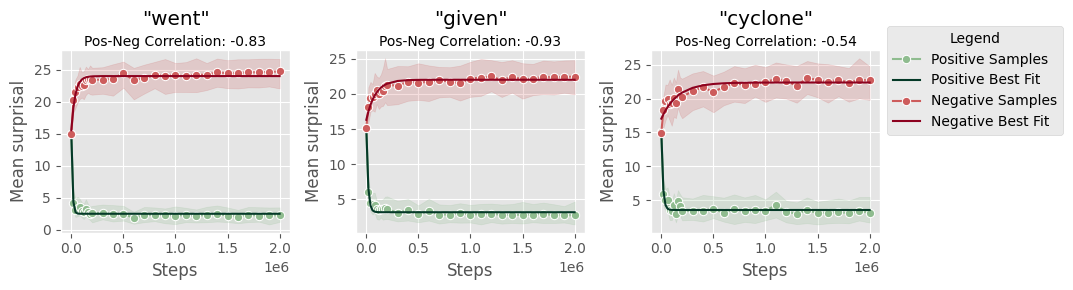

In [8]:
# 50 samples (e.g: "form", "went", "given")

words = token_counts[token_counts['count'] == 50].Token.sample(3)
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False)  

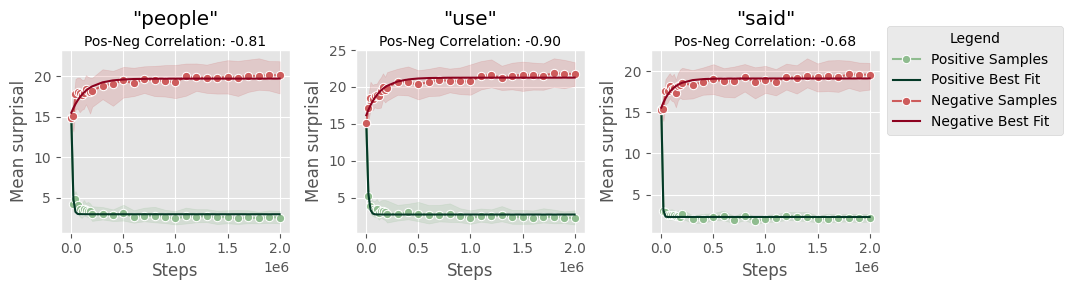

In [9]:
# 102 samples

words = token_counts[token_counts['count'] == 102].Token.sample(3)
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False)  

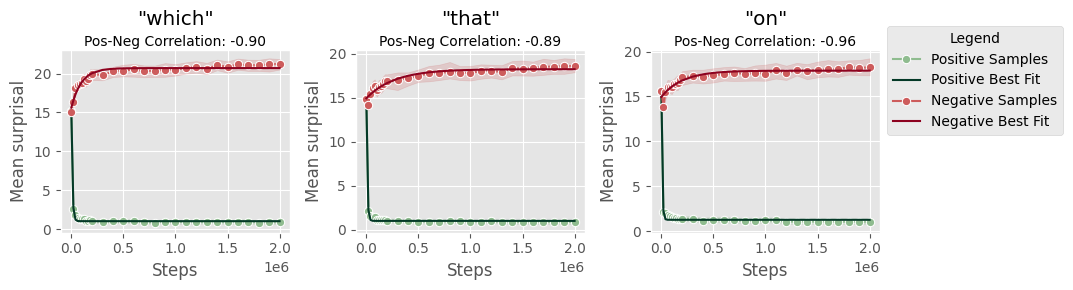

In [10]:
# 512 samples

words = token_counts[token_counts['count'] == 512].Token.sample(3)
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_curve=True, first_step=False)  

In [11]:
surprisals = indiv_surprisals[['Steps', 'Token', 'MeanSurprisal', 'MeanNegSurprisal']].drop_duplicates().reset_index(drop=True)
surprisals

,Steps,Token,MeanSurprisal,MeanNegSurprisal
0,0,a,14.225594,14.234500
1,0,aa,15.597247,15.751283
2,0,abandon,15.298998,15.042455
3,0,abandoned,14.781739,14.788133
4,0,abandoning,14.522403,14.334804
...,...,...,...,...
263257,2000000,zone,4.706525,22.451706
263258,2000000,zones,2.175875,23.845009
263259,2000000,zoo,5.894639,15.055669
263260,2000000,zoom,2.738938,13.967112


In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict

def trend_categories(df, first_step=True):

    def determine_trend(values):
        X = np.arange(len(values)).reshape(-1, 1)
        model = LinearRegression().fit(X, values)
        slope = model.coef_[0]
        return 'Increasing' if slope > 0 else 'Decreasing'

    categories = defaultdict(lambda: [0, []])

    if not first_step:
        df = df[df['Steps'] != 0]
        
    grouped = df.groupby('Token')
    
    for word, word_data in grouped:
        surprisal_values = word_data['MeanSurprisal'].values.reshape(-1, 1)
        antisurprisal_values = word_data['MeanNegSurprisal'].values.reshape(-1, 1)
        
        surprisal_trend = determine_trend(surprisal_values)
        antisurprisal_trend = determine_trend(antisurprisal_values)
        
        key = f"{surprisal_trend}-{antisurprisal_trend}"
        categories[key][0] += 1
        categories[key][1].append(word)
    
    return categories


In [68]:
# with first step
categories_29 = trend_categories(surprisals)
categories_df_29 = pd.DataFrame(categories_29, index=['count', 'words']).transpose()
categories_df_29

,count,words
Decreasing-Increasing,8309,"[a, aa, abandon, abandoned, abandoning, abando..."
Decreasing-Decreasing,487,"[abducted, abstract, academics, accommodations..."
Increasing-Increasing,243,"[absorption, accelerating, accessibility, acci..."
Increasing-Decreasing,39,"[arresting, banging, breakers, bump, caliber, ..."


In [69]:
# without first step
categories_28 = trend_categories(surprisals, first_step=False)
categories_df_28 = pd.DataFrame(categories_28, index=['count', 'words']).transpose()
categories_df_28

,count,words
Decreasing-Increasing,7633,"[a, aa, abandon, abandoned, abandoning, abbot,..."
Decreasing-Decreasing,849,"[abandonment, abdomen, abducted, absolutely, a..."
Increasing-Increasing,510,"[absorption, accelerating, acceptable, acciden..."
Increasing-Decreasing,86,"[accessibility, activist, ads, affiliation, am..."


In [66]:
# import random 

# words = categories_df_28['words'].apply(lambda x: random.choice(x))
# words

Decreasing-Increasing    credible
Decreasing-Decreasing       stole
Increasing-Increasing     harvest
Increasing-Decreasing    initiate
Name: words, dtype: object

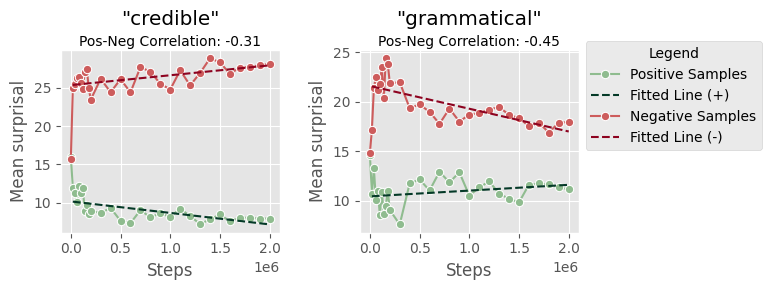

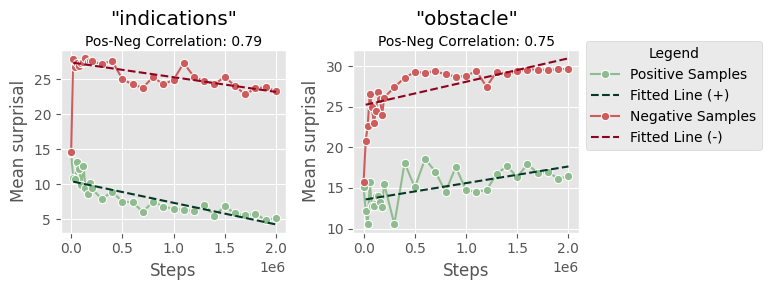

In [67]:
# Decreasing-Increasing: 'flesh'/'banned'/'regain'/'heating', 
# Increasing-Decreasing: 'comical'/'jewellery'/'outdoor'/'grammatical'
# Decreasing-Decreasing: 'creature'/'indications'
# Increasing-Increasing: 'neighbourhoods'/'silly'/'brow'/'predictions'/'obstacle'

words = ['credible', 'grammatical']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False)
words = ['indications', 'obstacle']
plot_surprisals(words, indiv_surprisals, show_error_interval=True, neg_samples=True, fit_line=True, first_step=False)